# Quelques fournitures pour le projet d'apprentissage semi-supervisé

## CIFAR-10

Il vous est demandé pour ce projet d'utiliser les données de la base de données CIFAR-10, que vous pouvez récupérer avec les quelques lignes ci-dessous. Cette base de données est constituée des 10 classes suivantes :


A vous de partager cette base en données labellisées et non labellisées en fonction des expériences que vous mènerez !

In [1]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [2]:
x_train.shape

(50000, 32, 32, 3)

## RandAugment

Pour implémenter l'augmentation forte dans FixMatch, vous aurez besoin d'une politique d'augmentation de données apprise par renforcement. La méthode RandAugment a été implémentée dans la bibliothèque imgaug, voici comment l'utiliser

In [ ]:
#!pip uninstall --yes imgaug
#!pip install imgaug==0.4.0

Found existing installation: imgaug 0.4.0
Uninstalling imgaug-0.4.0:
  Successfully uninstalled imgaug-0.4.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 KB 15.8 MB/s eta 0:00:00


In [ ]:
import imgaug.augmenters as iaa
aug = iaa.RandAugment(n=2, m=9)

def randaugment(img):
    return aug(images=img)

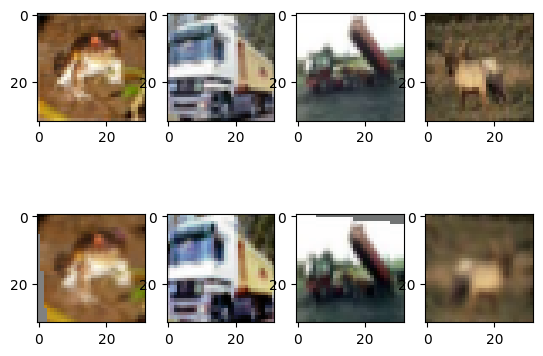

In [ ]:
import matplotlib.pyplot as plt

# Application de RandAugment aux 4 premières images de la base d'entraînement
aug_img = randaugment(x_train[0:4])

# Affichage des images originales (ligne du haut) et augmentées (ligne du bas)
for i in range(4):
    plt.subplot(2,4,i+1)
    plt.imshow(x_train[i])

    plt.subplot(2,4, i+5)
    plt.imshow(aug_img[i])

## Réseau fourni

Afin d'obtenir des résultats comparables, tout le monde devra utiliser le même réseau, que voici :

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential

def create_model():

    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same', input_shape=(32,32,3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(96, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(Dense(10,activation='softmax'))

    return model

In [ ]:
model = create_model()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 96)          55392     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 96)         0

# Apprentissage supervisé :

## Toutes les données d'entraînement

In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [ ]:
model.compile(optimizer= Adam(learning_rate=3e-4),
              loss= SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])

history = model.fit(x_train, y_train, batch_size = 16, epochs=100)


Epoch 1/100
3125/3125 [==============================] - 28s 5ms/step - loss: 1.6028 - sparse_categorical_accuracy: 0.4531
Epoch 2/100
3125/3125 [==============================] - 14s 5ms/step - loss: 1.1307 - sparse_categorical_accuracy: 0.6018
Epoch 3/100
3125/3125 [==============================] - 14s 5ms/step - loss: 0.9327 - sparse_categorical_accuracy: 0.6742
Epoch 4/100
3125/3125 [==============================] - 15s 5ms/step - loss: 0.7932 - sparse_categorical_accuracy: 0.7253
Epoch 5/100
3125/3125 [==============================] - 14s 5ms/step - loss: 0.6842 - sparse_categorical_accuracy: 0.7605
Epoch 6/100
3125/3125 [==============================] - 19s 6ms/step - loss: 0.5837 - sparse_categorical_accuracy: 0.7951
Epoch 7/100
3125/3125 [==============================] - 14s 5ms/step - loss: 0.5092 - sparse_categorical_accuracy: 0.8202
Epoch 8/100
3125/3125 [==============================] - 15s 5ms/step - loss: 0.4359 - sparse_categorical_accuracy: 0.8462
Epoch 9/100
3125

In [ ]:
model.evaluate(x_test,y_test)

313/313 [==============================] - 1s 3ms/step - loss: 4.4650 - sparse_categorical_accuracy: 0.7115


[4.465023994445801, 0.7114999890327454]

## 10% des données d'entraînement

ici on entraine le modèle avec 10% des données augmentées

### Générer les données :

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

def generate_data_cifar(pourcentage):
    #pourcentage c'est le pourcentage des données non labellisées
    #dans le cas supervisé c'est 1-pourcentage est la quantité des données utilisée pour l'entrainement du modèle

    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    #on génère les données lab et unlab de manière équilibrée vis à vis de la présence des différentes classes
    x_train_lab, x_train_unlab, y_train_lab, y_train_unlab = train_test_split(x_train, y_train, test_size=pourcentage, random_state=2, stratify=y_train)

    return x_train_lab, y_train_lab, x_train_unlab, y_train_unlab, x_test, y_test

In [ ]:
from tqdm import tqdm_notebook
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import math

# Données et modèle du problème
x_train_lab, y_train_lab, x_train_unlab, y_train_unlab, x_test, y_test = generate_data_cifar(pourcentage=0.9)
model = create_model()
#normalisation des données de test
x_test = x_test / 255.
# Hyperparamètres de l'apprentissage
epochs = 300
batch_size = 16
if batch_size < x_train_lab.shape[0]:
    steps_per_epoch = math.floor(x_train_lab.shape[0]/batch_size)
else:
    steps_per_epoch = 1
    batch_size = x_train_lab.shape[0]

# Instanciation d'un optimiseur et d'une fonction de coût.
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
loss_fn = SparseCategoricalCrossentropy()


# Préparation des métriques pour le suivi de la performance du modèle.
train_acc_metric = SparseCategoricalAccuracy()
test_acc_metric = SparseCategoricalAccuracy()

# Indices de l'ensemble labellisé
indices = np.arange(x_train_lab.shape[0])

train_acc_list = []
test_acc_list = []
train_loss_list = []
# Boucle sur les epochs
for epoch in tqdm_notebook(range(epochs)):

    # A chaque nouvelle epoch, on randomise les indices de l'ensemble labellisé
    np.random.shuffle(indices)

    # Et on recommence à cumuler la loss
    cum_loss_value = 0

    for step in range(steps_per_epoch):

        # Sélection des données du prochain batch
        x_batch = x_train_lab[indices[step*batch_size: (step+1)*batch_size]]
        y_batch = y_train_lab[indices[step*batch_size: (step+1)*batch_size]]
        # Etape nécessaire pour comparer y_batch à la sortie du réseau
        y_batch = np.expand_dims(y_batch, 1)

        #augmentation des données
        x_batch = randaugment(x_batch)
        #normalisation des données d'entrainement
        x_batch = x_batch / 255.

        # Les opérations effectuées par le modèle dans ce bloc sont suivies et permettront
        # la différentiation automatique.
        with tf.GradientTape() as tape:

            # Application du réseau aux données d'entrée
            y_pred = model(x_batch, training=True)  # Logits for this minibatch

            # Calcul de la fonction de perte sur ce batch
            loss_value = loss_fn(y_batch, y_pred)

            # Calcul des gradients par différentiation automatique
            grads = tape.gradient(loss_value, model.trainable_weights)

            # Réalisation d'une itération de la descente de gradient (mise à jour des paramètres du réseau)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            # Mise à jour de la métrique
            train_acc_metric.update_state(y_batch, y_pred)

            cum_loss_value = cum_loss_value + loss_value


    train_loss_list.append(float(cum_loss_value/steps_per_epoch))
    # Calcul de la précision à la fin de l'epoch
    train_acc = train_acc_metric.result()


    # Calcul de la précision sur l'ensemble de test à la fin de l'epoch
    test_logits = model(x_test, training=False)
    test_acc_metric.update_state(np.expand_dims(y_test, 1), test_logits)
    test_acc = test_acc_metric.result()

    tqdm.write("Epoch %4d : Loss : %.4f, Acc : %.4f, Test Acc : %.4f" % (epoch, float(cum_loss_value/steps_per_epoch), float(train_acc), float(test_acc)))

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    # Remise à zéro des métriques pour la prochaine epoch
    train_acc_metric.reset_states()
    test_acc_metric.reset_states()

<ipython-input-10-788f52b988f4>:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs)):


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch    0 : Loss : 2.2601, Acc : 0.1522, Test Acc : 0.2486
Epoch    1 : Loss : 2.1006, Acc : 0.2426, Test Acc : 0.3246
Epoch    2 : Loss : 2.0213, Acc : 0.2792, Test Acc : 0.3927
Epoch    3 : Loss : 1.9087, Acc : 0.3221, Test Acc : 0.4006
Epoch    4 : Loss : 1.8388, Acc : 0.3425, Test Acc : 0.4260
Epoch    5 : Loss : 1.7946, Acc : 0.3586, Test Acc : 0.4253
Epoch    6 : Loss : 1.7678, Acc : 0.3752, Test Acc : 0.4417
Epoch    7 : Loss : 1.7152, Acc : 0.3928, Test Acc : 0.4590
Epoch    8 : Loss : 1.6932, Acc : 0.4032, Test Acc : 0.4620
Epoch    9 : Loss : 1.6915, Acc : 0.3964, Test Acc : 0.4793
Epoch   10 : Loss : 1.6657, Acc : 0.4050, Test Acc : 0.4783
Epoch   11 : Loss : 1.6313, Acc : 0.4217, Test Acc : 0.4852
Epoch   12 : Loss : 1.6156, Acc : 0.4345, Test Acc : 0.4907
Epoch   13 : Loss : 1.6085, Acc : 0.4377, Test Acc : 0.4968
Epoch   14 : Loss : 1.5737, Acc : 0.4537, Test Acc : 0.4929
Epoch   15 : Loss : 1.5542, Acc : 0.4557, Test Acc : 0.5096
Epoch   16 : Loss : 1.5593, Acc : 0.4573

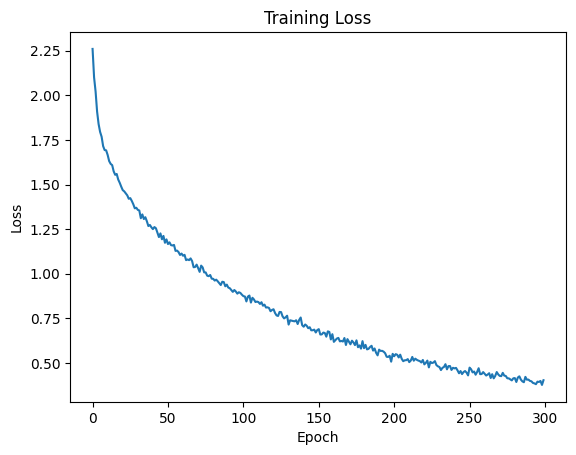

In [ ]:
plt.plot(train_loss_list)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

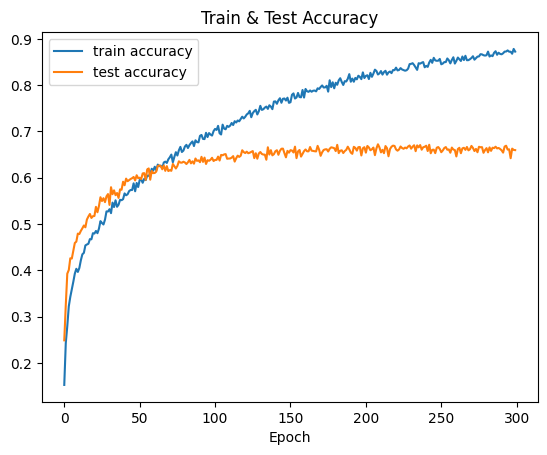

In [ ]:
plt.plot(train_acc_list, label = 'train accuracy')
plt.plot(test_acc_list, label = 'test accuracy')
plt.title('Train & Test Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## 5% des données d'entraînement

In [ ]:
from tqdm import tqdm, tqdm_notebook
import tensorflow as tf
from tensorflow import keras
import math

# Données et modèle du problème
x_train_lab, y_train_lab, x_train_unlab, y_train_unlab, x_test, y_test = generate_data_cifar(pourcentage=0.95)
model = create_model()

# Hyperparamètres de l'apprentissage
epochs = 300
batch_size = 16
if batch_size < x_train_lab.shape[0]:
    steps_per_epoch = math.floor(x_train_lab.shape[0]/batch_size)
else:
    steps_per_epoch = 1
    batch_size = x_train_lab.shape[0]

# Instanciation d'un optimiseur et d'une fonction de coût.
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
loss_fn = SparseCategoricalCrossentropy()


# Préparation des métriques pour le suivi de la performance du modèle.
train_acc_metric = SparseCategoricalAccuracy()
test_acc_metric = SparseCategoricalAccuracy()

# Indices de l'ensemble labellisé
indices = np.arange(x_train_lab.shape[0])

train_acc_list = []
test_acc_list = []
train_loss_list = []
# Boucle sur les epochs
for epoch in tqdm_notebook(range(epochs)):

    # A chaque nouvelle epoch, on randomise les indices de l'ensemble labellisé
    np.random.shuffle(indices)

    # Et on recommence à cumuler la loss
    cum_loss_value = 0

    for step in range(steps_per_epoch):

        # Sélection des données du prochain batch
        x_batch = x_train_lab[indices[step*batch_size: (step+1)*batch_size]]
        y_batch = y_train_lab[indices[step*batch_size: (step+1)*batch_size]]
        # Etape nécessaire pour comparer y_batch à la sortie du réseau
        y_batch = np.expand_dims(y_batch, 1)

        #augmentation des données
        x_batch = randaugment(x_batch)
        #normalisation des données d'entrainement
        x_batch = x_batch / 255.

        # Les opérations effectuées par le modèle dans ce bloc sont suivies et permettront
        # la différentiation automatique.
        with tf.GradientTape() as tape:

          # Application du réseau aux données d'entrée
          y_pred = model(x_batch, training=True)  # Logits for this minibatch

          # Calcul de la fonction de perte sur ce batch
          loss_value = loss_fn(y_batch, y_pred)

          # Calcul des gradients par différentiation automatique
          grads = tape.gradient(loss_value, model.trainable_weights)

          # Réalisation d'une itération de la descente de gradient (mise à jour des paramètres du réseau)
          optimizer.apply_gradients(zip(grads, model.trainable_weights))

          # Mise à jour de la métrique
          train_acc_metric.update_state(y_batch, y_pred)

          cum_loss_value = cum_loss_value + loss_value


    train_loss_list.append(float(cum_loss_value/steps_per_epoch))
    # Calcul de la précision à la fin de l'epoch
    train_acc = train_acc_metric.result()


    # Calcul de la précision sur l'ensemble de test à la fin de l'epoch
    test_logits = model(x_test, training=False)
    test_acc_metric.update_state(np.expand_dims(y_test, 1), test_logits)
    test_acc = test_acc_metric.result()

    tqdm.write("Epoch %4d : Loss : %.4f, Acc : %.4f, Test Acc : %.4f" % (epoch, float(cum_loss_value/steps_per_epoch), float(train_acc), float(test_acc)))

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    # Remise à zéro des métriques pour la prochaine epoch
    train_acc_metric.reset_states()
    test_acc_metric.reset_states()

<ipython-input-14-5dbde3a2f192>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs)):


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch    0 : Loss : 2.2989, Acc : 0.1042, Test Acc : 0.1236
Epoch    1 : Loss : 2.2501, Acc : 0.1715, Test Acc : 0.2705
Epoch    2 : Loss : 2.1338, Acc : 0.2260, Test Acc : 0.2861
Epoch    3 : Loss : 2.0675, Acc : 0.2616, Test Acc : 0.2845
Epoch    4 : Loss : 2.0247, Acc : 0.2668, Test Acc : 0.3334
Epoch    5 : Loss : 1.9447, Acc : 0.3081, Test Acc : 0.3624
Epoch    6 : Loss : 1.9047, Acc : 0.3113, Test Acc : 0.3571
Epoch    7 : Loss : 1.8511, Acc : 0.3333, Test Acc : 0.3907
Epoch    8 : Loss : 1.8145, Acc : 0.3389, Test Acc : 0.3936
Epoch    9 : Loss : 1.8061, Acc : 0.3458, Test Acc : 0.3673
Epoch   10 : Loss : 1.7688, Acc : 0.3662, Test Acc : 0.3908
Epoch   11 : Loss : 1.7635, Acc : 0.3614, Test Acc : 0.4053
Epoch   12 : Loss : 1.7497, Acc : 0.3722, Test Acc : 0.4191
Epoch   13 : Loss : 1.7250, Acc : 0.3810, Test Acc : 0.3998
Epoch   14 : Loss : 1.7188, Acc : 0.3822, Test Acc : 0.4229
Epoch   15 : Loss : 1.7169, Acc : 0.3874, Test Acc : 0.4062
Epoch   16 : Loss : 1.6746, Acc : 0.4006

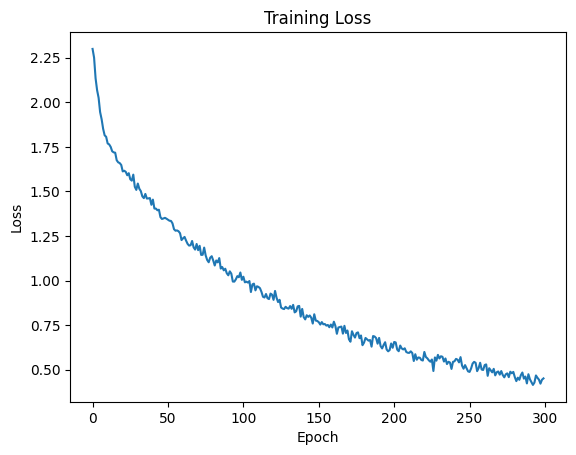

In [ ]:
plt.plot(train_loss_list)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

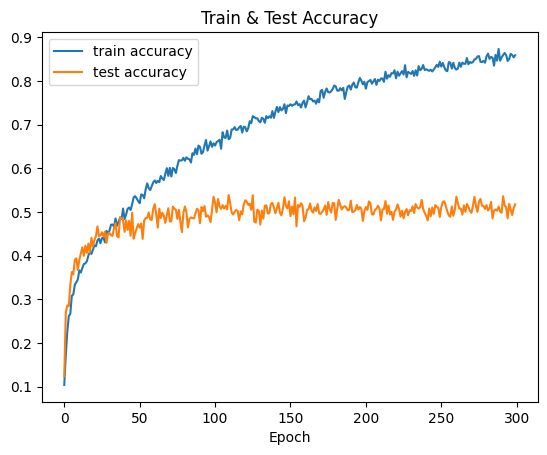

In [ ]:
plt.plot(train_acc_list, label = 'train accuracy')
plt.plot(test_acc_list, label = 'test accuracy')
plt.title('Train & Test Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## 1% des données

In [ ]:
from tqdm import tqdm, tqdm_notebook
import tensorflow as tf
from tensorflow import keras
import math

# Données et modèle du problème
x_train_lab, y_train_lab, x_train_unlab, y_train_unlab, x_test, y_test = generate_data_cifar(pourcentage=0.99)
model = create_model()

# Hyperparamètres de l'apprentissage
epochs = 300
batch_size = 16
if batch_size < x_train_lab.shape[0]:
    steps_per_epoch = math.floor(x_train_lab.shape[0]/batch_size)
else:
    steps_per_epoch = 1
    batch_size = x_train_lab.shape[0]

# Instanciation d'un optimiseur et d'une fonction de coût.
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
loss_fn = SparseCategoricalCrossentropy()


# Préparation des métriques pour le suivi de la performance du modèle.
train_acc_metric = SparseCategoricalAccuracy()
test_acc_metric = SparseCategoricalAccuracy()

# Indices de l'ensemble labellisé
indices = np.arange(x_train_lab.shape[0])

train_acc_list = []
test_acc_list = []
train_loss_list = []
# Boucle sur les epochs
for epoch in tqdm_notebook(range(epochs)):

    # A chaque nouvelle epoch, on randomise les indices de l'ensemble labellisé
    np.random.shuffle(indices)

    # Et on recommence à cumuler la loss
    cum_loss_value = 0

    for step in range(steps_per_epoch):

        # Sélection des données du prochain batch
        x_batch = x_train_lab[indices[step*batch_size: (step+1)*batch_size]]
        y_batch = y_train_lab[indices[step*batch_size: (step+1)*batch_size]]
        # Etape nécessaire pour comparer y_batch à la sortie du réseau
        y_batch = np.expand_dims(y_batch, 1)

        #augmentation des données
        x_batch = randaugment(x_batch)
        #normalisation des données d'entrainement
        x_batch = x_batch / 255.

        # Les opérations effectuées par le modèle dans ce bloc sont suivies et permettront
        # la différentiation automatique.
        with tf.GradientTape() as tape:

            # Application du réseau aux données d'entrée
            y_pred = model(x_batch, training=True)  # Logits for this minibatch

            # Calcul de la fonction de perte sur ce batch
            loss_value = loss_fn(y_batch, y_pred)

            # Calcul des gradients par différentiation automatique
            grads = tape.gradient(loss_value, model.trainable_weights)

            # Réalisation d'une itération de la descente de gradient (mise à jour des paramètres du réseau)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            # Mise à jour de la métrique
            train_acc_metric.update_state(y_batch, y_pred)

            cum_loss_value = cum_loss_value + loss_value


    train_loss_list.append(float(cum_loss_value/steps_per_epoch))
    # Calcul de la précision à la fin de l'epoch
    train_acc = train_acc_metric.result()


    # Calcul de la précision sur l'ensemble de test à la fin de l'epoch
    test_logits = model(x_test, training=False)
    test_acc_metric.update_state(np.expand_dims(y_test, 1), test_logits)
    test_acc = test_acc_metric.result()

    tqdm.write("Epoch %4d : Loss : %.4f, Acc : %.4f, Test Acc : %.4f" % (epoch, float(cum_loss_value/steps_per_epoch), float(train_acc), float(test_acc)))

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    # Remise à zéro des métriques pour la prochaine epoch
    train_acc_metric.reset_states()
    test_acc_metric.reset_states()

<ipython-input-17-a6d2c69feb7a>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs)):


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch    0 : Loss : 2.3072, Acc : 0.0706, Test Acc : 0.1103
Epoch    1 : Loss : 2.2999, Acc : 0.1290, Test Acc : 0.1644
Epoch    2 : Loss : 2.2984, Acc : 0.1431, Test Acc : 0.1492
Epoch    3 : Loss : 2.2927, Acc : 0.1492, Test Acc : 0.1853
Epoch    4 : Loss : 2.2825, Acc : 0.1694, Test Acc : 0.2349
Epoch    5 : Loss : 2.2695, Acc : 0.1835, Test Acc : 0.2561
Epoch    6 : Loss : 2.2430, Acc : 0.1774, Test Acc : 0.2513
Epoch    7 : Loss : 2.2105, Acc : 0.1794, Test Acc : 0.2857
Epoch    8 : Loss : 2.1623, Acc : 0.2097, Test Acc : 0.2788
Epoch    9 : Loss : 2.1183, Acc : 0.2258, Test Acc : 0.2556
Epoch   10 : Loss : 2.0840, Acc : 0.2177, Test Acc : 0.2668
Epoch   11 : Loss : 2.0667, Acc : 0.2520, Test Acc : 0.3316
Epoch   12 : Loss : 2.0697, Acc : 0.2379, Test Acc : 0.2605
Epoch   13 : Loss : 2.0638, Acc : 0.2177, Test Acc : 0.3377
Epoch   14 : Loss : 2.0125, Acc : 0.2903, Test Acc : 0.3027
Epoch   15 : Loss : 1.9773, Acc : 0.3125, Test Acc : 0.3466
Epoch   16 : Loss : 1.9532, Acc : 0.3044

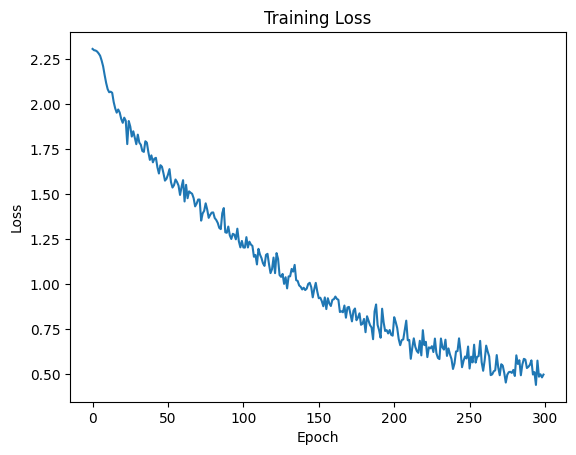

In [ ]:
plt.plot(train_loss_list)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

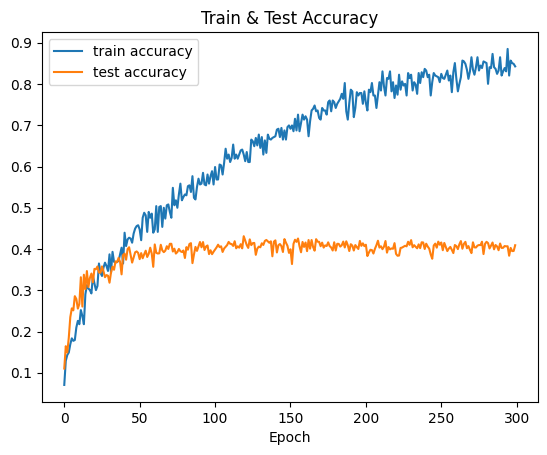

In [ ]:
plt.plot(train_acc_list, label = 'train accuracy')
plt.plot(test_acc_list, label = 'test accuracy')
plt.title('Train & Test Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()